### Prepare DEM input for discretization ###

Prepare DEM input data for the domain area. This step includes:<br>
1. project large-domain DEM raster into a specified projection system.
2. extract DEM for the domain area.
3. rasterize domain GRU shapefile based on domain DEM raster.
4. calculate slope and aspect for the domain area.
5. check correctness of slope and aspect.

In [2]:
# import libraries
import os
import geopandas as gpd
import rasterio as rio
from rasterio.warp import Resampling
import geospatial_functions.utils as ut
import geospatial_functions.geospatial_analysis as ga

In [3]:
# common paths
control_file = 'control_active.txt'
root_path = ut.read_from_control(control_file, 'root_path')
source_path = ut.read_from_control(control_file, 'source_path')
domain_name = ut.read_from_control(control_file, 'domain_name')
domain_path = os.path.join(root_path, domain_name)
plot_path = os.path.join(domain_path, 'plot')

In [ ]:
# projection system
proj4=ut.read_from_control(control_file, 'proj4') 
dst_crs = rio.crs.CRS.from_string(proj4)

In [4]:
# large-domain data
dem_raster = ut.read_from_control(control_file, 'dem_raster')
dem_prj_raster = ut.read_from_control(control_file, 'dem_prj_raster')
if dem_prj_raster == 'default':
    dem_prj_raster = os.path.join(source_path, os.path.basename(dem_raster).split('.tif')[0]+'_prj.tif')

# domain data
domain_gru_prj_shp = ut.specify_file_path(control_file, 'domain_gru_prj_shp') 
domain_dem_raster = ut.specify_file_path(control_file, 'domain_dem_raster')  
domain_slope_raster = ut.specify_file_path(control_file, 'domain_slope_raster')  
domain_aspect_raster = ut.specify_file_path(control_file, 'domain_aspect_raster') 
domain_stream_shp = ut.specify_file_path(control_file, 'domain_stream_shp')

huc12_field   = ut.read_from_control(control_file, 'huc12_field')      
gruNo_field = ut.read_from_control(control_file, 'gruNo_field')
gruNo_field_dtype= ut.read_from_control(control_file, 'gruNo_field_dtype')
gruName_field = ut.read_from_control(control_file, 'gruName_field')
domain_gru_raster  = ut.specify_file_path(control_file, 'domain_gru_raster')
domain_gru_corr_txt = ut.specify_file_path(control_file, 'domain_gru_corr_txt')

#### 1. Project larage-domain DEM #### 
Be carefule running it because it may take a long time given the size of the large-domian DEM data. <br>
If this operation has been done once, no need to repeat it for a new domain case study. In other words, this operation is really once for all.

In [5]:
ga.reproject_raster(dem_raster, dem_prj_raster, dst_crs, Resampling.bilinear)  

#### 2. Extract domain DEM ####

In [6]:
ga.crop_raster(dem_prj_raster, domain_gru_prj_shp, domain_dem_raster)

#### 3. Rasterize domain GRU shapefile based on domain DEM raster ####
Domain GRU raster will be used in HRU generation and zonal statistcs.

In [ ]:
refraster = ut.specify_refraster_path(control_file)
ga.rasterize_gru_vector(domain_gru_prj_shp,huc12_field,gruName_field,gruNo_field,gruNo_field_dtype,refraster,
                        domain_gru_raster,domain_gru_corr_txt)

#### 4. Calculate domain slope and aspect ####

In [7]:
# method 1: use numpy module
ga.calculate_slope_and_aspect(domain_dem_raster,domain_slope_raster,domain_aspect_raster)

In [8]:
# # method 2: use gdal module
# from osgeo import gdal
# gdal.UseExceptions()
# gdal.DEMProcessing(domain_slope_raster, domain_dem_raster, 'slope', computeEdges=True)
# gdal.DEMProcessing(domain_aspect_raster, domain_dem_raster, 'aspect',zeroForFlat=True)

#### 5a. Check slope and aspect results ####

<Figure size 432x288 with 0 Axes>

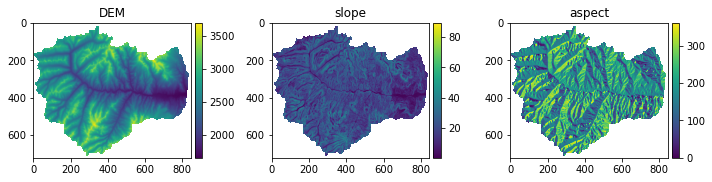

In [9]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def read_raster(file):   
    with rio.open(file) as ff:
        data  = ff.read(1)
        mask = ff.read_masks(1)
    data_ma = np.ma.masked_array(data, mask==0)
    return data_ma

def plot_locatable_axes(data, ax):
    # reference: https://matplotlib.org/stable/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(data)
    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()

plt.figure()
f, ax = plt.subplots(1,3, figsize=(10,10)) 

dem_ma = read_raster(domain_dem_raster)
plot_locatable_axes(dem_ma, ax[0])
ax[0].set_title('DEM')

slp_ma = read_raster(domain_slope_raster)
plot_locatable_axes(slp_ma, ax[1])
ax[1].set_title('slope')

asp_ma = read_raster(domain_aspect_raster)
plot_locatable_axes(asp_ma, ax[2])
ax[2].set_title('aspect')

plt.tight_layout()
plt.show()

#### 5b. Check aspect class ####

In [ ]:
# classify aspect into 8 classes
aspect_class_raster = os.path.join(domain_path, os.path.basename(domain_aspect_raster).split('.tif')[0]+'_class.tif')        
ga.classify_aspect(domain_aspect_raster, 8, aspect_class_raster)

In [15]:
import geospatial_functions.geospatial_plot as gp

# define legend dictionary. dist[raster_value]=list(color,label)
legend_dict={0:["black", "Flat (0)"],
             1:["red", "North (337.5 - 22.5)"],
             2:["orange", 'Northeast (22.5 - 67.5)'],
             3:["yellow", 'East (67.5 - 112.5)'], 
             4:["lime", 'Southeast (112.5 - 157.5)'], 
             5:["cyan", 'South (157.5 - 202.5)'], 
             6:["cornflowerblue", 'Southwest (202.5 - 247.5)'], 
             7:["blue", 'West (247.5 - 292.5)'], 
             8:["purple", 'Northwest (292.5 - 337.5)']} 

label_dict = {0:"Flat (0)",
              1:"North (337.7 - 22.5)",
              2:'Northeast (22.5 - 67.5)',
              3:'East (67.5 - 112.5)', 
              4:'Southeast (112.5 - 157.5)', 
              5:'South (157.5 - 202.5)', 
              6:'Southwest (202.5 - 247.5)', 
              7:'West (247.5 - 292.5)', 
              8:'Northwest (292.5 - 337.5)'}

wgs_crs = 'epsg:4326'
figsize=(9,9*0.6) # width, height in inches
title = domain_name.capitalize()+' aspect class'
leg_ncol=2
leg_loc='upper center'
leg_bbox_to_anchor=(0.5,-0.15)

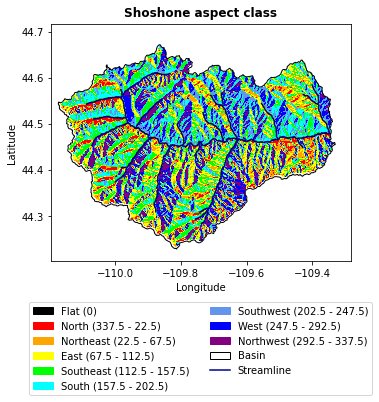

In [16]:
# plot classified aspect
ofile = os.path.join(plot_path, 'aspect_class_and_bound_stream.png')   

inraster,bound_vector,stream_vector,wgs_crs,cmap_str,input_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile=\
aspect_class_raster,domain_gru_prj_shp,domain_stream_shp,wgs_crs,'user',legend_dict,figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile

gp.plot_raster_and_bound_stream(inraster,bound_vector,stream_vector,wgs_crs,cmap_str,input_dict,
                                figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,ofile)